# Praca domowa 2
#### Mateusz Grzyb

## Wczytanie pakietów

In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder 
from category_encoders import BinaryEncoder
from category_encoders import OrdinalEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error

# do ewnetualnego podgladu calych ramek
#from IPython.display import display
#pd.set_option('display.max_columns', None)

## Wczytanie danych

In [67]:
data=pd.read_csv('allegro-api-transactions.csv')

data.loc[1:3, ]

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.9,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.9,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.5,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy


## Typy zmiennych i braki danych

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 14 columns):
lp                        420020 non-null int64
date                      420020 non-null object
item_id                   420020 non-null int64
categories                420020 non-null object
pay_option_on_delivery    420020 non-null int64
pay_option_transfer       420020 non-null int64
seller                    420020 non-null object
price                     420020 non-null float64
it_is_allegro_standard    420020 non-null int64
it_quantity               420020 non-null int64
it_is_brand_zone          420020 non-null int64
it_seller_rating          420020 non-null int64
it_location               420020 non-null object
main_category             420020 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 44.9+ MB


#### Komentarz
Dane obejmują 420020 aukcji, zmienne są typów int, float i string, nie występują wartości null.

## Kodowanie zmiennych kategorycznych

### Target Encoding zmiennej it_location

In [69]:
data_te=data.copy()

# ujednolicenie wielkosci liter w nazwach miejscowosci
data_te.it_location=data_te.it_location.str.lower()

te=TargetEncoder()
data_te['it_location_encoded']=te.fit_transform(data_te['it_location'], data_te['price'])

data_te.loc[1:3, ['item_id', 'it_location', 'it_location_encoded']]

,item_id,it_location,it_location_encoded
1,4773181874,warszawa,84.132898
2,4781627074,leszno,64.883187
3,4783971474,wola krzysztoporska,35.433365


#### Komentarz
W nowo utworzonej kolumnie it_location_encoded lokalizacja produktu została pomyślnie zastąpiona "... with a blend of the expected value of the target given particular categorical value and the expected value of the target over all the training data.".

Przewagą Target Encodingu nad One-hot Encodingiem jest niezwiększanie liczby wymiarów ramki danych, na której został użyty.

#### Uwaga
Poniższy przykład pokazuje, że dane w ramce wciąż nie są jednolite (błędy w pisowni, nieużywanie polskich liter diakrytyzowanych). W rzeczywistym scenariuszu należałoby te dane ujednolicić, jednak ponieważ uważam to za mozolną i niezbyt rozwijającą pracę (i co ważniejsze, nie trenuję modelu), nie będę tego tutaj robił.

In [70]:
data_te.loc[[4, 41449], ['item_id', 'it_location', 'it_location_encoded']]

,item_id,it_location,it_location_encoded
4,4787908274,białystok,73.772916
41449,6097012880,bialystok,29.990468


### Trzy metody Encodingu zmiennej main_category

#### One-hot Encoding

In [71]:
data_ohe=data.copy()

ohe=OneHotEncoder(sparse=False)
temp=pd.DataFrame(ohe.fit_transform(data_ohe[['main_category']]))
temp.columns=ohe.get_feature_names(['main_category'])
data_ohe=pd.concat([data_ohe, temp], axis=1)

data_ohe.loc[1:3, np.concatenate((np.array(['item_id']), np.array([c for c in data_ohe if c[0:4]=='main'])), axis=None)]

,item_id,main_category,main_category_Antyki i Sztuka,main_category_Bilety,main_category_Biuro i Reklama,main_category_Biżuteria i Zegarki,main_category_Delikatesy,main_category_Dla Dzieci,main_category_Dom i Ogród,main_category_Filmy,...,main_category_Nieruchomości,"main_category_Odzież, Obuwie, Dodatki",main_category_Przemysł,main_category_RTV i AGD,main_category_Rękodzieło,main_category_Sport i Turystyka,"main_category_Sprzęt estradowy, studyjny i DJ-ski",main_category_Telefony i Akcesoria,main_category_Uroda,main_category_Zdrowie
1,4773181874,"Odzież, Obuwie, Dodatki",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4781627074,Dom i Ogród,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4783971474,Książki i Komiksy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Komentarz
One-hot Encoding pomyślnie zastąpił kolumnę main_category 27 binarnymi kolumnami main_category_(nazwa kategorii), po jednej na każdą kategorię.

Liczba wymiarów ramki danych znacznie wzrosła.

#### Binary Encoding

In [72]:
data_be=data.copy()

be=BinaryEncoder()
temp=be.fit_transform(data_be['main_category'])
data_be=pd.concat([data_be, temp], axis=1)

data_be.loc[1:3, np.concatenate((np.array(['item_id']), np.array([c for c in data_be if c[0:4]=='main'])), axis=None)]

,item_id,main_category,main_category_0,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5
1,4773181874,"Odzież, Obuwie, Dodatki",0,0,0,0,1,0
2,4781627074,Dom i Ogród,0,0,0,0,1,1
3,4783971474,Książki i Komiksy,0,0,0,1,0,0


#### Komentarz

Binary Encoding pomyślnie zastąpił kolumnę main_category 5 binarnymi kolumnami main_category_(1-5). Tym razem, poszczególne kategorie kodowane są przez liczby w systemie dwójkowym, zapisane we wszystkich 5 nowych kolumnach.

Liczba wymiarów ramki wzrosła, ale nie tak bardzo, jak w przypadku One-hot Encodingu.

#### Ordinal Encoding

In [73]:
data_oe=data.copy()

oe=OrdinalEncoder()
data_oe['main_category_encoded']=oe.fit_transform(data_oe['main_category'])


data_oe.loc[1:3, ['item_id', 'main_category', 'main_category_encoded']]

,item_id,main_category,main_category_encoded
1,4773181874,"Odzież, Obuwie, Dodatki",2
2,4781627074,Dom i Ogród,3
3,4783971474,Książki i Komiksy,4


#### Komentarz
Ordinal Encoding pomyślnie zastąpił kolumnę main_category kolumną main_category_encoded, w której poszczególne kategorie kodowane są przez liczby naturalne. Nie świadczy to o występowaniu relacji większości/mniejszości pomiędzy kategoriami - "... the classes are assumed to have no true order and integers are selected at random."

Liczba wymiarów ramki nie wzrosła.

## Uzupełnianie braków
Zdecydowałem się na użycie Multivariate Feature Imputation.
### Przygotowanie danych

In [74]:
data_true=data.copy()
data_true=data_true.loc[:, ['price', 'it_seller_rating', 'it_quantity']]

data_true.describe()

,price,it_seller_rating,it_quantity
count,420020.000000,420020.000000,420020.000000
mean,76.811350,20402.593496,6748.274823
std,390.326271,36682.898636,23387.248064
min,0.000000,-1.000000,0.000000
25%,9.000000,1581.000000,6.000000
50%,24.990000,6711.000000,95.000000
75%,68.450000,21007.000000,931.000000
max,119000.000000,292074.000000,99999.000000


### Imputacja zmiennej it_seller_rating

In [75]:
RMSEs1=[]
imp=IterativeImputer(max_iter=10)

for i in range(10):
    data_null=data.copy()
    data_null=data_null.loc[:, ['price', 'it_seller_rating', 'it_quantity']]
    data_null.loc[data_null.sample(len(data_null)//10).index, 'it_seller_rating']=None

    data_imputed=pd.DataFrame(imp.fit_transform(data_null))

    RMSEs1.append(np.sqrt(mean_squared_error(data_true, data_imputed)))
    
print('Średnie RMSE wynosi: '+str(round(np.mean(RMSEs1))))
print('Odchylenie standardowe RMSE wynosi: '+str(round(np.std(RMSEs1))))

Średnie RMSE wynosi: 6707.0
Odchylenie standardowe RMSE wynosi: 63.0


#### Komentarz
Odchylenie standardowe RMSE jest małe, więc eksperyment uznaję za przeprowadzony poprawnie. Średnie RMSE jest dosyć duże, w odniesienu do statystyk pozycyjnych zmiennej it_seller_rating (minimalna wartość = -1, maksymalna wartość 292074, średnia ~ 20403). Sprawdźmy, czy algorytm miał szansę na trafniejsze wnioskowanie: 

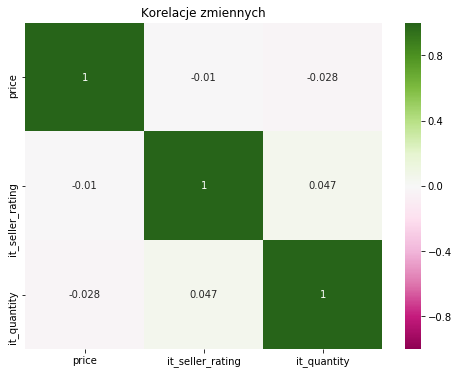

In [76]:
corr=data_true.corr()
fig, ax=plt.subplots(figsize=(8,6))  
ax=sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap="PiYG", center=0, vmin=-1, vmax=1)
ax.set_title('Korelacje zmiennych')
plt.show();

Jak widać, korelacje zmiennych w ramce danych są bardzo małe. Nie jest zatem zaskoczeniem, że wyniki algorytmu nie były dobre.

### Imputacja zmiennych it_seller_rating i it_quantity

In [77]:
RMSEs2=[]

for i in range(10):
    data_null=data.copy()
    data_null=data_null.loc[:, ['price', 'it_seller_rating', 'it_quantity']]
    data_null.loc[data_null.sample(len(data_null)//10).index, 'it_seller_rating']=None
    data_null.loc[data_null.sample(len(data_null)//10).index, 'it_quantity']=None

    data_imputed=pd.DataFrame(imp.fit_transform(data_null))

    RMSEs2.append(np.sqrt(mean_squared_error(data_true, data_imputed)))
    
print('Średnie RMSE wynosi: '+str(np.mean(RMSEs2)))
print('Odchylenie standardowe RMSE wynosi: '+str(np.std(RMSEs2)))

Średnie RMSE wynosi: 7921.619832059053
Odchylenie standardowe RMSE wynosi: 53.71465938278901


#### Komentarz

Odchylenie standardowe RMSE jest małe, więc eksperyment uznaję za przeprowadzony poprawnie. Średnie RMSE znacznie wzrosło. Zgodnie ze wcześniejszą analizą, nie jest to zaskoczeniem. Struktura danych (bardzo małe korelacje zmiennych) uniemożliwia algorytmowi trafne wnioskowanie. Nie jest zatem zaskoczeniem, że im więcej braków algorytm uzupełnia, tym większa jest rozbieżność względem prawdziwych wartości.

#### Wizualizacja wyników

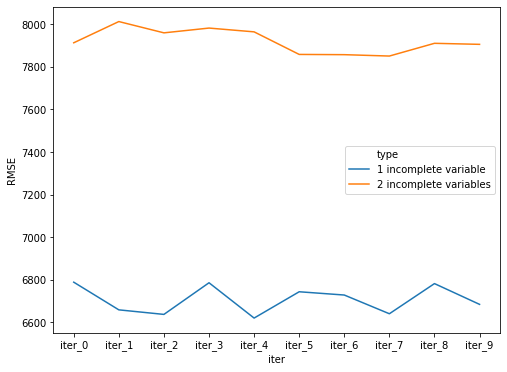

In [78]:
pd.DataFrame(['1 incomplete variable', '2 incomplete variables'])
types=pd.DataFrame(['2 incomplete variables' if (i>=10) else '1 incomplete variable' for i in range(20)]).reset_index(drop=True)
iters=pd.DataFrame(['iter_'+str(i%10) for i in range(20)]).reset_index(drop=True)
RMSEs1=pd.DataFrame(RMSEs1)
RMSEs2=pd.DataFrame(RMSEs2)
RMSEs=pd.concat([RMSEs1, RMSEs2]).reset_index(drop=True)
RMSEs=pd.concat([types, iters, RMSEs], axis=1)
RMSEs.columns=['type', 'iter', 'RMSE']

fig, ax=plt.subplots(figsize=(8,6))
sns.lineplot(data=RMSEs, x='iter', y='RMSE', hue='type');

#### Komentarz
Wyniki omówiłem już powyżej, tutaj jest tylko ich wizualizacja.